# Spin-Hamiltonian Simulation Using CUDA-Q

This tutorial demonstrates how to perform one-dimensional spin-Hamiltonian simulations. We will focus on simulating the time evolution of spin chains with the Heisenberg and Transverse Field Ising Model (TFIM) Hamiltonians using Trotter-Suzuki decomposition.

## Introduction

Simulating quantum systems is a key problem to solve in quantum computing. The Heisenberg and TFIM Hamiltonians are models that describe interactions in spin chains, which are essential in understanding, as an example, magnetic properties of materials and quantum phase transitions.

### Heisenberg Hamiltonian

The Heisenberg Hamiltonian for a one-dimensional spin chain with nearest-neighbor interactions is given by:

$$
H = \sum_{i} \left( J_x S_i^x S_{i+1}^x + J_y S_i^y S_{i+1}^y + J_z S_i^z S_{i+1}^z \right)
$$

- $S_i^\alpha$ are the spin operators (Pauli matrices) acting on spin $i$ in the $ \alpha$-direction ( $\alpha = x, y, z$).
- $J_x, J_y, J_z$ are the coupling coefficients between spins.

---

### Transverse Field Ising Model (TFIM)

The TFIM Hamiltonian is a simplified model focusing on the competition between an external transverse magnetic field and nearest-neighbor spin interactions:

$$
H = -h \sum_i S_i^x - \sum_i S_i^z S_{i+1}^z
$$

- $h$ is the strength of the transverse magnetic field.
- The first term represents the interaction of spins with the external field in the $x$-direction.
- The second term represents the interaction between neighboring spins in the $z$-direction.

---

### Time Evolution and Trotter Decomposition

To simulate the time evolution $e^{-iHt}$ of these Hamiltonians, we use the Trotter-Suzuki decomposition, which approximates the exponential of a sum of non-commuting operators by a product of exponentials of individual terms:

$$
e^{-iHt} \approx \left( e^{-iH_1 \Delta t} e^{-iH_2 \Delta t} \cdots e^{-iH_n \Delta t} \right)^K
$$

- $\Delta t = t / K$ is the time step.
- $K$ is the number of Trotter steps.
- $H_i$ are the individual terms in the Hamiltonian.



In [1]:
# Import Required Libraries
import cudaq
import numpy as np
import time
import sys
from cudaq import spin
import matplotlib.pyplot as plt
from typing import List

## Key steps

### 1. Prepare initial state

Prepare the initial quantum state of the system. For this simulation, we create the state $|0101\ldots\rangle$, where every odd qubit is in the $|1\rangle$ state, and every even qubit is in the $|0\rangle$ state.

In [2]:
@cudaq.kernel
def get_initial_state(n_spins: int):
    """Create initial state |1010...>"""
    qubits = cudaq.qvector(n_spins)
    for i in range(0, n_spins, 2):
        x(qubits[i])
        

### 2. Hamiltonian Trotterization

This function performs a single Trotter step for simulating a spin chain. If `_use_XXYYZZ_gate` is True, it constructs specific two-qubit gates using decomposition for exponentiation. It is a custom and efficient exponentiation combination of XX+YY+ZZ gates as a single operation. Otherwise, it uses a standrd CUDA-Q exp_pauli operation for the exponentiation of Pauli gates in Hamiltonian.
Input parameters:
- **state:** The current quantum state.  
- **dt:** Time step for Trotter evolution.  
- **Jx, Jy, Jz:** Coupling constants for the spin-spin interactions along the x, y, and z axes.  
- **h_x, h_y, h_z:** Local magnetic field strengths (unused in the code provided).  
- **`_use_XXYYZZ_gate`:** Flag to determine if custom XX+YY+ZZ gates should be used.  
- **coefficients:** Coefficients of Pauli terms for exponential evolution.  
- **words:** Corresponding Pauli operators (e.g., X, Y, Z) for evolution.  

In [3]:
@cudaq.kernel
def trotter_step(state: cudaq.State, dt: float, Jx: float, Jy: float, Jz: float,
                 h_x: list[float], h_y: list[float], h_z: list[float], _use_XXYYZZ_gate: bool,
                 coefficients: List[complex], words: List[cudaq.pauli_word]):
    """Perform single Trotter step"""
    qubits = cudaq.qvector(state)
    n_spins = len(qubits)
   
    # Apply two-qubit interaction terms
    if _use_XXYYZZ_gate:
        for j in range(2):
            for i in range(j % 2, n_spins - 1, 2):
                rx(-np.pi/2,qubits[i])
                rx(np.pi/2,qubits[i+1])
                x.ctrl(qubits[i], qubits[i+1])
                h(qubits[i])
                s(qubits[i])
                rz(-2*Jy*dt,qubits[i+1])
                x.ctrl(qubits[i], qubits[i+1])
                h(qubits[i])
                rx(2*Jx*dt,qubits[i])
                rz(-2*Jz*dt,qubits[i+1])
                x.ctrl(qubits[i], qubits[i+1])
    else:
        for i in range(len(coefficients)):
            exp_pauli(coefficients[i].real * dt, qubits, words[i])

### 3. `Compute overlap`

Calculate the probability of the evolved state overlapping with the initial state.

In [4]:
def compute_overlap_probability(initial_state: cudaq.State, evolved_state: cudaq.State):
    """Compute probability of the overlap with the initial state"""
    overlap = initial_state.overlap(evolved_state)
    return np.abs(overlap)**2

### 4. Construct Heisenberg Hamiltonian

Construct the Heisenberg Hamiltonian as a `cudaq.SpinOperator` object, considering nearest-neighbor interactions along X, Y, and Z directions. It supports arbitrary coupling constants Jx, Jy, and Jz. See formula above.
Input:
- **`n_spins`**: Number of spins (qubits) in the system.  
- **`Jx`, `Jy`, `Jz`**: Coupling constants for interactions in the X, Y, and Z directions.  
- **`h_x`, `h_y`, `h_z`**: Magnetic field components (currently unused).  

In [5]:
def create_hamiltonian_heisenberg(n_spins: int, Jx: float, Jy: float, Jz: float, h_x: list[float], h_y: list[float], h_z: list[float]):
    """Create the Hamiltonian operator"""
    ham = 0

    # Add two-qubit interaction terms for Heisenberg Hamiltonian
    for i in range(0, n_spins - 1):
        ham += Jx * spin.x(i) * spin.x(i + 1)
        ham += Jy * spin.y(i) * spin.y(i + 1)
        ham += Jz * spin.z(i) * spin.z(i + 1)
   
    return ham

### 5. Construct TFIM Hamiltonian

Construct the TFIM Hamiltonian as a `cudaq.SpinOperator` object. See formula above.

In [6]:
def create_hamiltonian_tfim(n_spins: int, h_field: float):
    """Create the Hamiltonian operator"""
    ham = 0
   
    # Add single-qubit terms
    for i in range(0, n_spins):
        ham += -1 * h_field * spin.x(i)

    # Add two-qubit interaction terms for Ising Hamiltonian
    for i in range(0, n_spins-1):
        ham += -1 * spin.z(i) * spin.z(i + 1)
   
    return ham

### 6. Extract coefficients and Pauli words

Extract the coefficients and Pauli words from the provided Hamiltonian for use in the Trotter step.

In [7]:
def extractCoefficients(hamiltonian: cudaq.SpinOperator):
    result = []
    for term in hamiltonian:
        result.append(term.get_coefficient())
    return result

def extractWords(hamiltonian: cudaq.SpinOperator):
    # Our kernel uses these words to apply exp_pauli to the entire state.
    # we hence ensure that each pauli word covers the entire space.
    n_spins = hamiltonian.get_qubit_count()
    result = []
    for term in hamiltonian:
        result.append(term.get_pauli_word(n_spins))
    return result

## Main code

Import required libraries, set up the simulation parameters, and perform the time evolution.

In [8]:
# Import Required Libraries
import cudaq
import numpy as np
import time
import sys
from cudaq import spin
import matplotlib.pyplot as plt
from typing import List

# Parameters
n_spins = 4  # Number of spins in the chain
ham_type = "heisenberg"  # Choose between "heisenberg" and "tfim"
Jx, Jy, Jz = 1.0, 1.0, 1.0  # Coupling coefficients for Heisenberg Hamiltonian
h_field = 1.0  # Transverse field strength for TFIM
K = 100  # Number of Trotter steps
t = np.pi  # Total evolution time
dt = t / K  # Time step size

# Optimized XXYYZZ exponentiation. Works only for Heisenberg Hamiltonian
_use_XXYYZZ_gate = False
if _use_XXYYZZ_gate == True and ham_type == "tfim":
    print ("XXYYZZ exponentiation works only for Heisenberg")
    sys.exit(0)

# Create Hamiltonian
if ham_type == "heisenberg":
    # Initialize field for Heisenberg Hamiltonian
    h_x = np.ones(n_spins)
    h_y = np.ones(n_spins)
    h_z = np.ones(n_spins)
    hamiltonian = create_hamiltonian_heisenberg(n_spins, Jx, Jy, Jz, h_x, h_y,h_z)
elif ham_type == "tfim":
    hamiltonian = create_hamiltonian_tfim(n_spins, h_field)
else:
    raise ValueError("Invalid Hamiltonian type. Choose 'heisenberg' or 'tfim'.")

# Extract coefficients and words
coefficients = extractCoefficients(hamiltonian)
words = extractWords(hamiltonian)

# Initialize and save the initial state
print ("Initialize state")
initial_state = cudaq.get_state(get_initial_state, n_spins)
state = initial_state

# Store probabilities over time
probabilities = []
probabilities.append(1.0)

# Time evolution
start_time = time.time()
for k in range(1, K):

    # Apply single Trotter step
    state = cudaq.get_state(trotter_step, state, dt, Jx, Jy, Jz, h_x, h_y, h_z, _use_XXYYZZ_gate, coefficients, words)

    # Calculate probability between initial and current states
    probability = compute_overlap_probability(initial_state, state)
    probabilities.append(probability)

total_time = time.time() - start_time
print(f"Circuit execution time: {total_time:.3f} seconds")

/tmp/ipykernel_393541/1011071069.py:4: DeprecationWarning: use `evaluate_coefficient` instead
  result.append(term.get_coefficient())
/tmp/ipykernel_393541/1011071069.py:10: DeprecationWarning: use `qubit_count` instead
  n_spins = hamiltonian.get_qubit_count()


Initialize state
Circuit execution time: 2.244 seconds


## Visualization of probablity over time

Plot the probability of the system remaining in the initial state as a function of time.

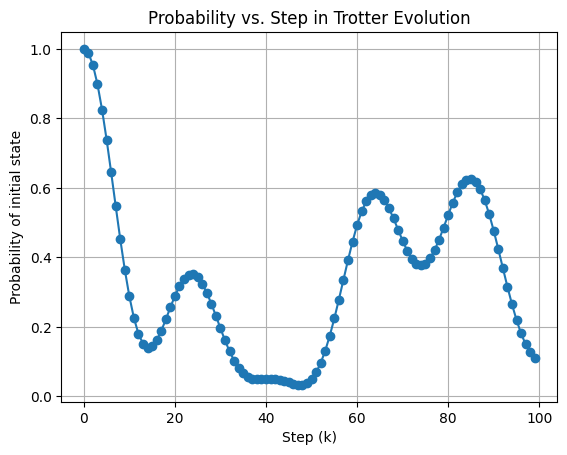

In [9]:
# Plot probability over time
plt.plot(range(K), probabilities, marker='o')
plt.xlabel('Step (k)')
plt.ylabel('Probability of initial state')
plt.title('Probability vs. Step in Trotter Evolution')
plt.grid()
plt.show()

## Expectation value over time: 

Set up the simulation parameters, perform the time evolution, and visualize results for expectation value over time.

In [10]:
# Initialize list to store expectation values
exp_values = []

# Time evolution
start_time = time.time()
for k in range(1, K):
    # Apply single Trotter step
    state = cudaq.get_state(trotter_step, state, dt, Jx, Jy, Jz, h_x, h_y, h_z, _use_XXYYZZ_gate, coefficients, words)

    # Calculate expectation value
    exp_val = cudaq.observe(trotter_step, hamiltonian, state, dt, Jx, Jy, Jz, h_x, h_y, h_z, _use_XXYYZZ_gate, coefficients, words).expectation()
    exp_values.append(exp_val.real)
    #print(f"Step {k}, Energy: {exp_val.real:.6f}")

## Visualization of expectation over time

Plot the expectation value over time.

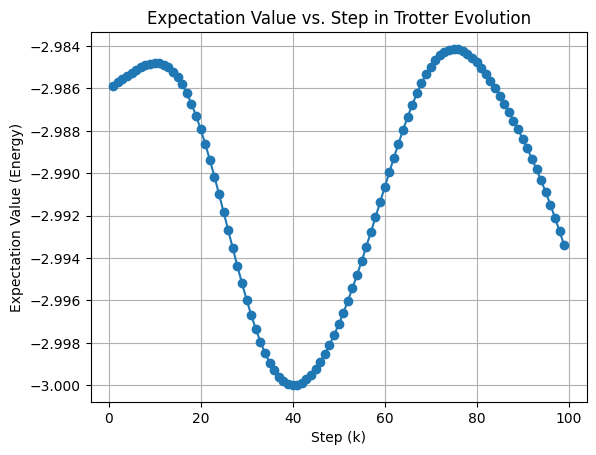

In [11]:
# Plot expectation value over time
x = np.arange(1, K)
plt.plot(x, exp_values, marker='o')
plt.xlabel('Step (k)')
plt.ylabel('Expectation Value (Energy)')
plt.title('Expectation Value vs. Step in Trotter Evolution')
plt.grid()
plt.show()

## Additional information

In the code above, we relied on CUDA-Q expectation of Pauli gates. If we needed to do it manually here is how it is done.

In [12]:
@cudaq.kernel
def xx_gate(qubits: cudaq.qview, tau: float) -> None:
    """XX gate implementation"""
    h(qubits[0])
    h(qubits[1])
    x.ctrl(qubits[0], qubits[1])
    rz(np.pi * tau, qubits[1])
    x.ctrl(qubits[0], qubits[1])
    h(qubits[0])
    h(qubits[1])

@cudaq.kernel
def yy_gate(qubits: cudaq.qview, tau: float) -> None:
    """YY gate implementation"""
    # S gates (equivalent to rz(pi/2))
    rz(np.pi/2, qubits[0])
    rz(np.pi/2, qubits[1])
    
    h(qubits[0])
    h(qubits[1])
    x.ctrl(qubits[0], qubits[1])
    rz(np.pi * tau, qubits[1])
    x.ctrl(qubits[0], qubits[1])
    h(qubits[0])
    h(qubits[1])
    
    # S inverse gates (equivalent to rz(-pi/2))
    rz(-np.pi/2, qubits[0])
    rz(-np.pi/2, qubits[1])

@cudaq.kernel
def zz_gate(qubits: cudaq.qview, tau: float) -> None:
    """ZZ gate implementation"""
    x.ctrl(qubits[0], qubits[1])
    rz(np.pi * tau, qubits[1])
    x.ctrl(qubits[0], qubits[1])

## Relevant references

- https://nvidia.github.io/cuda-quantum/latest/examples/python/operators.html
- https://arxiv.org/abs/quant-ph/9503016

In [13]:
print(cudaq.__version__)

CUDA-Q Version proto-0.8.0 (https://github.com/NVIDIA/cuda-quantum d5e0513d54809a835d1c2c108c0692be10d7d1bb)
